CODE TO CONVERT FROM TIME-DOMAIN

Import modules

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as xp
import plotly.io as pio; pio.renderers.default = "iframe"
from scipy import signal
import os

Upload .CSV File
Needs to be in the time-domain. Double-check the directory and path of the files being read and output.
Example of file path directory: C:\Users\DBaltazar\FF.csv

In [168]:
# Inpute direct file path for the time-domain CSV file INSIDE the quotation marks
output_file_name = str(input("Name of the output files: "))
filename = os.path.abspath(r"C:\Users\DBaltazar\FF.csv")

Name of the output files:  tuyp


In [169]:
df = pd.read_csv(filename) #load the data
df = df.set_index(df.columns[0]) #set the first column as the index
df # To double-check the right file was pulled up

,-0.03103,-0.02501,0.03435
4.54236,,,
4.54238,-0.00982,-0.01814,0.01649
4.54240,-0.00942,-0.02333,0.04777
4.54242,0.00702,-0.01100,0.04656
4.54244,0.00424,-0.01870,0.03300
4.54246,-0.00478,-0.02823,0.06253
...,...,...,...
8.61146,0.02161,0.00666,-0.04484
8.61148,0.03991,0.01297,-0.06189
8.61150,0.02718,0.00484,-0.05115


Basic Analysis of Time-Domain
Gathers the following descriptions:
- Peak Acceleration (max g's experienced) (Dependant on Sample Rate)
- Grms (total acceleration experienced) (Independant of Sample Rate)
- Crest Factor (Peak / grms) (Defines the sharpness of the spike; and indicator of bearing failure)

In [149]:
abs_max = df.abs().max() #maximum of the absolute values, the peak
std = df.std() #standard deviation (equivalent to the AC coupled RMS value)
crest_factor = abs_max/std #crest factor (peak / RMS)

stats = pd.concat([abs_max, #combine the stats into one table
                   std,
                   crest_factor],
                  axis=1)
stats.columns = ['Peak Acceleration (g)','RMS (g)','Crest Factor'] #set the headers of the table
stats

,Peak Acceleration (g),RMS (g),Crest Factor
-0.03103,50.32973,2.064290,24.381138
-0.02501,53.04711,2.541091,20.875726
0.03435,104.33089,6.223432,16.764205


Time-Domain Acceleration Curve
Plots the information directly on the csv file (which s/b the time-domain acceleration curve)
Does not capture the full frequency range and spectrum as well.

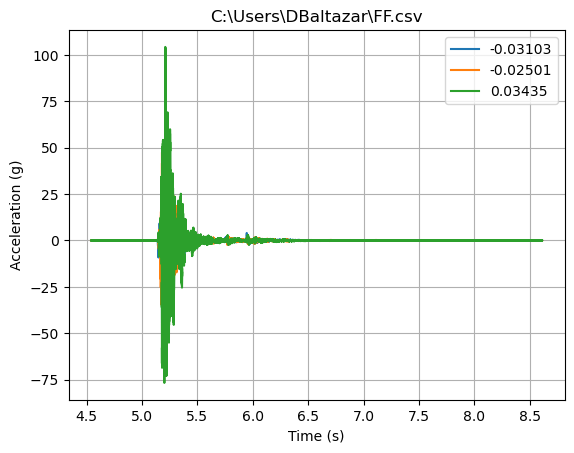

In [150]:
fig, ax = plt.subplots() #create an empty plot

df.plot(ax=ax) #use the dataframe to add plot data, tell it to add to the already created axes

ax.set(xlabel='Time (s)',
       ylabel='Acceleration (g)',
       title=filename)
ax.grid() #turn on gridlines

fig_name = output_file_name + "_full-time-history.png"
fig.savefig(fig_name)
plt.show()

Rolling RMS Values
Plots the rolling RMS values from rolling peaks
Breaks up the data into 'n_steps" sections and calculates the max abs values, then the rms values from that
Especially useful for generating curves to use as inputs into simulations

In [151]:
# Calculates Rolling Peak First

n_steps = 100 #number of points to plot
n = int(df.shape[0]/n_steps) #number of data points to use in windowing
df_rolling_peak = df.abs().rolling(n).max().iloc[::n] #finds the absolute value of every datapoint, then does a rolling maximum of the defined window size, then subsamples every nth point

In [152]:
# Calculates Rolling RMS Values

df_rolling_rms = df.rolling(n).std().iloc[::n] #does a rolling standard deviation of the defined window size, then subsamples every nth point

fig = xp.line(df_rolling_rms)
fig.update_layout(
    title="Rolling RMS",
    xaxis_title="Time (s)",
    yaxis_title="Acceleration (g)",
    template="plotly_dark"
)
fig.show()
html_name = output_file_name + "_rolling_rms.html"
fig.write_html(html_name,full_html=False,include_plotlyjs='cdn')

PSD Curve (Welch)
Converts time-domain to frequency-domain and generates PSD curve and csv using the Welch function
- Has adjustable bin dwiths to smooth data while maintaining overall energy in each frequency b/c of normalization
- Square root of area under the curve gives the Grms
- Easier integration to Velocity (for total energy) and displacement (for intuitive analysis)

In [153]:
def get_psd(df, bin_width=1.0, window="hann"):
    d_t = (df.index[-1]-df.index[0])/(len(df.index)-1)
    fs = 1/d_t
    f, psd = signal.welch(
        df.values, fs=fs, nperseg= int(fs / bin_width), window=window, axis=0
    )

    df_psd = pd.DataFrame(psd, columns=df.columns)
    df_psd["Frequency (Hz)"] = f
    df_psd = df_psd.set_index("Frequency (Hz)")
    return df_psd

In [154]:
# Generates a CSV File of the PSD Curve
df_psd = get_psd(df,bin_width=4) #compute a PSD with a 1 Hz bin width
psd_name = output_file_name + "_psd_excel.csv"
df_psd.to_csv(psd_name) #save to a CSV file

In [155]:
# Plots the PSD Curve
fig = xp.line(df_psd)
fig.update_layout(
    title="Power Spectral Density (PSD)",
    xaxis_title="Frequency (Hz)",
    yaxis_title="Acceleration (g^2/Hz)",
    xaxis_type="log",
    yaxis_type="log"
)
fig.show()
psd_html_name = output_file_name + "_psd_html.html"
fig.write_html(psd_html_name,full_html=False,include_plotlyjs='cdn')

Cumulative RMS
Calculates Grms value at a given frequency range (basically the area under the PSD curve)

In [156]:
def rms_from_psd(df_psd):
    d_f = df_psd.index[1] - df_psd.index[0]
    df_rms = df_psd.copy()
    df_rms = df_rms*d_f
    df_rms = df_rms.cumsum()
    return(df_rms**0.5)

In [157]:
df_rms = rms_from_psd(df_psd)

fig = xp.line(df_rms)
fig.update_layout(
    title="Cumulative RMS",
    xaxis_title="Frequency (Hz)",
    yaxis_title="Acceleration (g RMS)",
    xaxis_type="log",
    #yaxis_type="log"
)
fig.show()
cum_rms_name = output_file_name + "_cum_rms.html"
fig.write_html(cum_rms_name,full_html=False,include_plotlyjs='cdn')

FFT Curve
Converts time-domain to frequency-domain and generates FFT curve to analyze frequency changes
Useful for finding phase angle (since PSD is normalized), but susceptible to frequency leakage

In [158]:
from scipy.fft import fft, fftfreq

def get_fft(df):
    N=len(df)
    fs = len(df)/(df.index[-1]-df.index[0])

    x_plot= fftfreq(N, 1/fs)[:N//2]

    df_fft = pd.DataFrame()
    df_phase = pd.DataFrame()
    for name in df.columns:
        yf = fft(df[name].values)
        y_plot= 2.0/N * np.abs(yf[0:N//2])

        phase = np.unwrap(2 * np.angle(yf)) / 2 * 180/np.pi
        phase = phase[0:N//2]

        df_phase = pd.concat([df_phase,
                            pd.DataFrame({'Frequency (Hz)':x_plot[1:],
                                          name:phase[1:]}).set_index('Frequency (Hz)')],axis=1)
        df_fft = pd.concat([df_fft,
                            pd.DataFrame({'Frequency (Hz)':x_plot[1:],
                                          name:y_plot[1:]}).set_index('Frequency (Hz)')],axis=1)

    return df_fft, df_phase

df_fft, df_phase = get_fft(df)

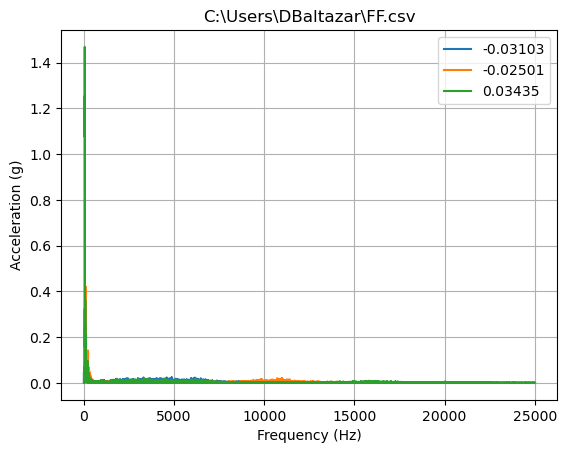

In [159]:
fig, ax = plt.subplots() #create an empty plot

df_fft.plot(ax=ax) #use the dataframe to add plot data, tell it to add to the already created axes

ax.set(xlabel='Frequency (Hz)',
       ylabel='Acceleration (g)',
       title=filename)
ax.grid() #turn on gridlines

fft_name = output_file_name + "_fft.png"
fig.savefig(fft_name)
plt.show()

FFT Curve from PSD*** (Still Under Consideration)
Creates an FFT curve from the PSD data, which allows to analyze intensity while being able to control frequency resolution
Should have the benefits of a PSD curve, but with Phase Angle included (?)

In [160]:
def get_fft_from_psd(df,bin_width):
  fs = len(df)/(df.index[-1]-df.index[0])
  f, psd = signal.welch(df.to_numpy(),
                        fs=fs,
                        nperseg=fs/bin_width,
                        window='hann',
                        axis=0,
                        scaling = 'spectrum'
                        )

  df_psd = pd.DataFrame(psd**0.5,columns=df.columns)
  df_psd.columns
  df_psd['Frequency (Hz)'] = f
  return df_psd.set_index('Frequency (Hz)')

In [161]:
df_fft_from_psd = get_fft_from_psd(df,.25)

fig = xp.line(df_fft_from_psd)
fig.update_layout(
    title="FFT from PSD",
    xaxis_title="Frequency (Hz)",
    yaxis_title="Acceleration (g)",
    #xaxis_type="log",
    #yaxis_type="log"
)
fig.show()
fft_from_psd = output_file_name + "_fft_from_psd.html"
fig.write_html(fft_from_psd,full_html=False,include_plotlyjs='cdn')